In [4]:
!pip install pandas

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [6]:
!pip install seaborn

In [7]:
!pip install keras

In [14]:
!pip install nltk

In [16]:
!pip install Tokenizer

In [18]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
!pip install cufflinks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00


In [20]:
!pip install chart-studio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [5]:
# Try listing the contents of the MyDrive folder to verify the file is there
!ls /content/drive/MyDrive/Colab\ Notebooks

# If the file is present and the path is correct, try reading the CSV again
# pd.read_csv('/content/drive/MyDrive/consumer_complaints_small.csv')

# It's a good practice to assign the dataframe to a variable, e.g., df
df = pd.read_csv('/content/drive/MyDrive/consumer_complaints.csv')


 consumer_complaints.csv
 kecerdasanbuatan.ipynb
'Multi-Class Text Classification LSTM Consumer complaints.ipynb'
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb


In [9]:
df.head()



,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
0,0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,"Premium Asset Services, LLC",In progress,Yes,NaN
1,1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN
2,2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,RBS Citizens,Closed with explanation,Yes,Yes
3,3,1291615,Credit card,NaN,Other,NaN,CA,92592.0,2015-03-19,2015-03-19,Navy FCU,In progress,Yes,NaN
4,4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,43068.0,2015-03-19,2015-03-19,Transworld Systems Inc.,In progress,Yes,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            28156 non-null  int64  
 1   Complaint ID          28156 non-null  int64  
 2   Product               28156 non-null  object 
 3   Sub-product           17582 non-null  object 
 4   Issue                 28154 non-null  object 
 5   Sub-issue             13211 non-null  object 
 6   State                 27735 non-null  object 
 7   ZIP code              27876 non-null  float64
 8   Date received         28156 non-null  object 
 9   Date sent to company  28156 non-null  object 
 10  Company               28156 non-null  object 
 11  Company response      28156 non-null  object 
 12  Timely response?      28156 non-null  object 
 13  Consumer disputed?    6006 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 3.0+ MB


In [11]:
df.Product.value_counts()

,count
Product,
Debt collection,7494
Mortgage,6612
Credit reporting,5717
Credit card,2830
Bank account or service,2609
Consumer loan,1314
Student loan,785
Payday loan,348
Money transfers,232


In [12]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [15]:
import plotly.express as px

product_counts = df['Product'].value_counts().sort_values(ascending=False)

fig = px.bar(product_counts,
             x=product_counts.index,
             y=product_counts.values,
             labels={'x': 'Product', 'y': 'Number of Complaints'},
             title='Number of Complaints in Each Product')

fig.show()

In [29]:
def print_plot(index):
    # Check the actual column names in your DataFrame
    # print(df.columns)
    # If 'Consumer complaint narrative' has a trailing space or is spelled differently,
    # update the column name below to match the actual name in your DataFrame.
    example = df[df.index == index][['Consumer complaint narrative','Product']].values[0] # Assuming the issue is a trailing space
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [31]:
print(df.index)


RangeIndex(start=0, stop=5, step=1)


In [37]:
def print_plot(idx):
    if idx < 0 or idx >= len(df):
        print(f"Index {idx} out of bounds for dataframe with length {len(df)}")
        return
    example = df.iloc[idx][['Consumer complaint narrative', 'Product']]
    print(example['Consumer complaint narrative'])
    print('Product:', example['Product'])


In [38]:
print_plot(5)

Index 5 out of bounds for dataframe with length 5


In [39]:
print_plot(100)

Index 100 out of bounds for dataframe with length 5


In [40]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

In [41]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

In [42]:
print_plot(10)

Index 10 out of bounds for dataframe with length 5


In [43]:
print_plot(100)

Index 100 out of bounds for dataframe with length 5


In [44]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20 unique tokens.


In [45]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5, 250)


In [46]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5, 5)


In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4, 250) (4, 5)
(1, 250) (1, 5)


In [53]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))  # <-- ubah sesuai jumlah kelas label kamu
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [74]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step - accuracy: 1.0000 - loss: 0.9763 - val_accuracy: 0.0000e+00 - val_loss: 4.4863
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step - accuracy: 1.0000 - loss: 0.8701 - val_accuracy: 0.0000e+00 - val_loss: 4.6685
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step - accuracy: 0.6667 - loss: 1.0476 - val_accuracy: 0.0000e+00 - val_loss: 4.8289
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6667 - loss: 1.0200 - val_accuracy: 0.0000e+00 - val_loss: 4.9772


In [75]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.0000e+00 - loss: 4.9785
Test set
  Loss: 4.979
  Accuracy: 0.000


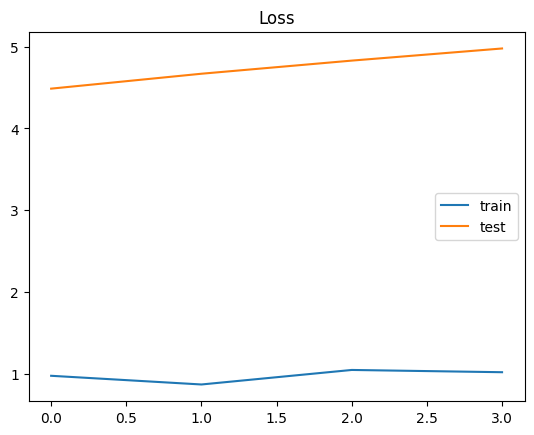

In [76]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

Text(0.5, 1.0, 'Accuracy')

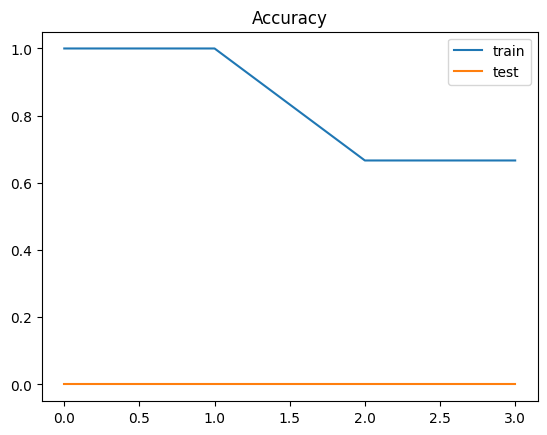

In [77]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [78]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[[0.41757464 0.00728612 0.269368   0.29864722 0.00712401]] Credit reporting, credit repair services, or other personal consumer reports
